# CM50270 Reinforcement Learning: Coursework 3 (Mountain Car)

Please remember: 
(1) Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.
(2) Save your work regularly. 

###  Code for Mountain Car 

We provide a `MountainCar` class that you can use. This implementation is based on the problem description given in [Example 8.2](http://www.incompleteideas.net/book/ebook/node89.html) of Sutton & Barto (1998) The following cells in this section will walk you through the basic usage of this class.

We import the mountaincar module and create a `MountainCar` object called `env`. The `reset()` method chooses a random starting `position` and starting `velocity` for the car, and sets the `game_over` variable to `False`. You can access these state variables independently using the same names.

In [ ]:
import numpy as np
import mountaincar

np.random.seed(7)

env = mountaincar.MountainCar()
env.reset()
print("Starting position of the car", env.position)
print("Starting velocity of the car", env.velocity)
if not env.game_over:
    print("Game is not over yet.")

You can visualize the current position of the car using the `plot()` method.

In [ ]:
env.plot()

You can interact with the `MountainCar` environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. This method returns a `reward` signal, which is always -1.

The action can be one of the following integers:
* -1: full throttle reverse
*  0: zero throttle
*  1: full throttle forward

In [ ]:
# Let's drive a bit full throttle forward and plot again.
env.make_step(action=1)
env.make_step(action=1)
env.make_step(action=1)
env.plot()

The following code snippet shows that even at full throttle the car cannot accelerate up the steep slope.

In [ ]:
num_steps = 150
for episode in range(num_steps):
    # Always action 1 (full throttle forward)
    env.make_step(action=1)
    env.plot()

## Part 1 (50 marks):

For your reference, the pseudo-code for  _Linear, gradient-descent Sarsa($\lambda$)_ is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, [Section 8.4](http://www.incompleteideas.net/book/ebook/node89.html#fig:FAsarsa).
<img src="images/gradient_descent_Sarsa.png" style="width: 500px;"/>

Please plot an average learning curve for your agent. This should be a static figure of _precomputed_ results, clearly showing (1) how efficiently an average agent learns, and (2) how good the eventual policy is. In five sentences or less, describe your choice of parameter settings and your results.

In addition, please write code to produce a learning curve for a _single_ agent. This shoud be a dynamic figure that we can produce from scratch by executing your code. This figure can show less detail than the static plot. 


In [1]:
import mountaincar
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:

class SarsaAgent():
    
    def __init__(self, alpha, gamma, epsilon, lambda_):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.theta = np.zeros((10,10,10,3))
    
    def reset(self):
        self.theta = np.zeros((10,10,10,3))
    
    def choose_action(self, state, actions, tilings):
        if np.random.uniform(0, 1) < self.epsilon:
            action = random.choice(actions)
            Q = self.calcQ(state, tilings)
            return action, Q[action + 1]
        else:
            Q = self.calcQ(state, tilings)
            maxQ = max(Q)
            if (Q == maxQ).sum() > 1:
                best = [i for i in range(len(actions)) if Q[i] == maxQ]
                i = random.choice(best)
            else:
                i = np.argmax(Q)

        action = actions[i]
        return action, Q[action + 1]

    def choose_random_action(self, actions):
        return random.choice(actions)
    
    def calcQ(self, state, tilings):
        Q = np.zeros(3)
        for a in [-1, 0, 1]:
            F = tileCode(state, a + 1, tilings)
            for i in F:
                Q[a + 1] = Q[a + 1] + self.theta[i[0], i[1], i[2], i[3]]
            #mult = self.theta * set_of_features
            #Q[a + 1] = np.sum(mult)
#            for i in range(10):
#                for j in range(10):
#                    for k in range(10):
#                        for l in range(3):
#                            if mult[i, j, k, l] > 0:
#                                print(i, j, k, l, "\tValue:", mult[i, j, k, l])
        #print("Q:", Q)
        return Q


In [16]:

def createTiling():    
    num_tiles = 10
    min_x = -1.2
    max_x = 0.5
    x_tile_width = (max_x - min_x) / (num_tiles - 2)
    min_y = -0.07
    max_y = 0.07
    y_tile_width = (max_y - min_y) / (num_tiles - 2)
    
    #tiles = np.zeros((10,4), dtype=np.int)
    tilings = np.zeros((10, 2, 10))
    
    for tiling in range(num_tiles):
        x_offset = np.random.uniform(0, x_tile_width)
        #print("X offset:", x_offset)
        y_offset = np.random.uniform(0, y_tile_width)     
        xs = np.linspace(min_x, max_x + x_tile_width, num_tiles) - x_offset
        #print(np.linspace(min_x, max_x + x_tile_width, num_tiles))
        ys = np.linspace(min_y, max_y + y_tile_width, num_tiles) - y_offset
        #print(np.linspace(min_y, max_y + y_tile_width, num_tiles))
        tilings[tiling] = np.array([xs, ys])
        
    return tilings

def tileCode(state, action, tilings):
    position = np.array(state[0])
    velocity = np.array(state[1])
    num_tiles = len(tilings)
    tiles = np.zeros((10,4), dtype=np.int)
    #tiles_ = np.zeros((10,10,10,3))
    for tiling in range(num_tiles):
        xs = tilings[tiling][0]
        ys = tilings[tiling][1]
        xi = np.digitize(position, xs)
        yi = np.digitize(velocity, ys)
        #print(xi, yi)
        feature = np.array([xi, yi, tiling, action])
        #print(feature)
        tiles[tiling] = feature
        #tiles_[xi, yi, tiling, action] = 1
    return tiles


In [32]:
env.reset()
state = np.array([env.position, env.velocity])
print(state)
action = -1
tilings_test = createTiling()
#print(tilings_test[0])
F = tileCode(state, action+1, tilings_test)
print(F)
#print(np.nonzero(set_of_features))
#for i in range(10):
#    for j in range(10):
#        for k in range(10):
#            for l in range(3):
#                if set_of_features[i, j, k, l] == 1:
#                    print(i, j, k, l)
#print(set_of_features)
#i = set_of_features[0]
#sarsa_agent = SarsaAgent(alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9)
#print(sarsa_agent.theta[i[0], i[1], i[2], i[3]])

[ 0.39125364 -0.01621785]
[[9 4 0 0]
 [9 4 1 0]
 [9 4 2 0]
 [8 5 3 0]
 [8 4 4 0]
 [8 4 5 0]
 [8 4 6 0]
 [9 4 7 0]
 [9 4 8 0]
 [8 4 9 0]]


In [33]:

def play(env, sarsa_agent, num_episodes, plot=False):
    alpha = sarsa_agent.alpha
    gamma = sarsa_agent.gamma
    lambda_ = sarsa_agent.lambda_
    
    reward_per_episode = np.zeros(num_episodes)
    steps_per_episode = np.zeros(num_episodes)
    
    # Get tilings
    tilings = createTiling()
    
    for episode in range(num_episodes):
        
        cumulative_reward = 0
        step = 0

        e = np.zeros((10, 10, 10, 3))
        env.reset()
        
        # Get starting state and action
        state = np.array([env.position, env.velocity])
        action = sarsa_agent.choose_random_action(env.actions)
        
        while not env.game_over:
            #print("State", state, "Action:", action)
            F = tileCode(state, action + 1, tilings)
            #e = e + set_of_features
            #e[e > 1] = 1 # replacing traces
            for i in F:
                e[i[0], i[1], i[2], i[3]] = 1
            
            # Make step and get reward and next state
            reward = env.make_step(action)
            new_state = np.array([env.position, env.velocity])
            
            # Calculate Q and then TD error
            Q = sarsa_agent.calcQ(new_state, tilings)
            delta = reward - Q[action + 1] # add 1 to action to get index (-1, 0, 1)->(0,1,2)
            #print("Delta:", delta)
            
            # Get chosen action and corresponding value
            action, Qa = sarsa_agent.choose_action(new_state, env.actions, tilings)
            #print(Qa)
            
            # Update delta, theta and e
            delta = delta + gamma * Qa
            #print("Delta:", delta)
            sarsa_agent.theta = sarsa_agent.theta + alpha * delta * e
            e = gamma * lambda_ * e
            
            # Set s = s'
            state = np.copy(new_state)
            
            # Increment step counter and cumulative reward
            step += 1
            cumulative_reward += reward
            
            if plot == True:
                env.plot()
                
        reward_per_episode[episode] = cumulative_reward
        steps_per_episode[episode] = step
    
    print("complete")
    return reward_per_episode, steps_per_episode
            

In [ ]:
n_agents = 1
num_episodes = 100
all_rewards = np.zeros(num_episodes)
all_steps = np.zeros(num_episodes)
for i in range(n_agents):
    sarsa_agent = SarsaAgent(alpha=0.1, gamma=1.0, epsilon=0.05, lambda_=0.9)
    env = mountaincar.MountainCar()
    rewards, steps = play(env, sarsa_agent, num_episodes, plot=False)
    all_rewards += rewards
    all_steps += steps

all_rewards = all_rewards / n_agents
all_steps = all_steps / n_agents

In [ ]:
# Moving average function is not mine and was taken from the following link:
# https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
# Credit: Jaime
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
play(env, sarsa_agent, num_episodes=5, plot=True)

[-3.8430e+03 -4.8970e+03 -6.0960e+03 -8.7800e+03 -4.4740e+03 -1.5770e+03
 -4.4060e+03 -3.6040e+03 -9.3700e+02 -4.1900e+02 -2.6130e+03 -4.2530e+03
 -6.7650e+03 -1.3450e+03 -1.1854e+04 -6.6750e+03 -1.0141e+04 -5.0680e+03
 -7.1900e+02 -2.8500e+02 -2.9600e+02 -2.9000e+02 -1.0800e+02 -2.2100e+02
 -7.8000e+01 -2.5460e+03 -2.7000e+01 -6.2400e+02 -6.5000e+01 -2.7100e+02
 -1.2331e+04 -5.9000e+01 -3.9820e+03 -1.1500e+02 -2.3400e+02 -8.1000e+01
 -5.0000e+01 -8.8000e+01 -6.0000e+01 -5.4000e+01 -6.2000e+01 -9.0000e+00
 -4.0000e+01 -8.6000e+01 -9.6000e+01 -2.4900e+02 -2.3000e+01 -7.3000e+01
 -2.1500e+02 -6.5000e+01 -2.0400e+02 -2.0000e+00 -5.8000e+01 -7.9000e+01
 -2.0400e+02 -5.1000e+01 -1.8200e+02 -1.4000e+01 -3.0000e+00 -2.7000e+01
 -2.2000e+01 -1.0700e+02 -4.0000e+00 -2.0000e+00 -1.4600e+02 -2.7000e+01
 -2.0800e+02 -3.0300e+02 -6.5000e+01 -4.8000e+01 -5.6000e+01 -1.1000e+01
 -6.0000e+01 -1.3200e+02 -2.3000e+01 -2.7000e+01 -8.4000e+01 -2.8000e+01
 -1.6650e+03 -2.2160e+03 -4.3620e+03 -2.9400e+02 -3

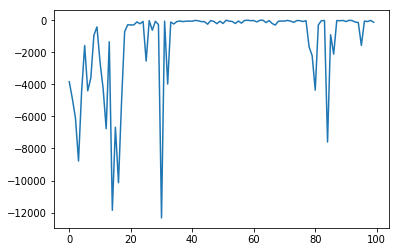

In [10]:
#print(all_rewards)

plt.plot(all_rewards)
plt.show()

Please make sure that all of your code is above this cell. Here, please insert your static learning curve and answer the verbal questions (describe your choice of parameters and results). 

YOUR ANSWER HERE



## Part 2 (50 marks)


In [ ]:
# Please write your code in this cell. You can add additional code cells below this one, if you would like to.
# ...

Please make sure that all of your code is above this cell. Please insert a static learning curve, showing the performance of your learning over time, and answer the questions provided on the coursework specification. Instead of providing your answer here, in this Jupyter notebook, you have the option to provide your answers on a separate pdf document, not exceeding two pages in length. If you do so, please write "Answer in pdf file." in this cell.  

YOUR ANSWER HERE

